In [1]:
import torch
from transformers import AdamW, get_scheduler, AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Import PEFT components
from peft import PeftConfig, PeftModel  # Make sure you have the 'peft' library installed

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Load the PEFT model configuration and base model
config = PeftConfig.from_pretrained("cyrp/distilbert-base-uncased-lora-text-classification-toxicchat-jailbreak")
base_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model = PeftModel.from_pretrained(base_model, "cyrp/distilbert-base-uncased-lora-text-classification-toxicchat-jailbreak")

# Check for MPS device and set it as the default device if available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
print("Using device:", device)

model.to(device)

# Define a dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Function to load and preprocess data
def load_data(file_path):
    data = pd.read_csv(file_path)
    data = data.dropna(subset=['text', 'label'])  # Remove rows with NaN in 'text' or 'is_offensive'
    data['text'] = data['text'].astype(str)  # Ensure all entries in 'text' are strings
    return data["text"].tolist(), data["label"].tolist()

# Load separate CSV files
train_texts, train_labels = load_data("train_data_new.csv")
val_texts, val_labels = load_data("validate_data_new.csv")
test_texts, test_labels = load_data("test_data_new.csv")

# Create Datasets
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Fine-tune the model
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc="Training", leave=False)
    for batch in progress_bar:
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        progress_bar.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Training Loss: {avg_loss:.4f}")

    # Validation after each epoch
    model.eval()
    val_losses = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        progress_bar = tqdm(val_dataloader, desc="Validation", leave=False)
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_losses.append(loss.item())

            # Get predictions
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate validation metrics
    average_val_loss = np.mean(val_losses)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds, zero_division=0)
    val_recall = recall_score(all_labels, all_preds, zero_division=0)
    val_f1 = f1_score(all_labels, all_preds, zero_division=0)

    print(f"Validation Loss: {average_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")

    model.train()  # Switch back to training mode

# Evaluation on test set
print("\nEvaluating on Test Set...")
model.eval()
test_losses = []
test_labels_list = []
test_preds_list = []

with torch.no_grad():
    progress_bar = tqdm(test_dataloader, desc="Testing", leave=False)
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        test_losses.append(loss.item())

        # Get predictions
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_labels_list.extend(labels.cpu().numpy())
        test_preds_list.extend(preds.cpu().numpy())

# Calculate test metrics
average_test_loss = np.mean(test_losses)
test_accuracy = accuracy_score(test_labels_list, test_preds_list)
test_precision = precision_score(test_labels_list, test_preds_list, zero_division=0)
test_recall = recall_score(test_labels_list, test_preds_list, zero_division=0)
test_f1 = f1_score(test_labels_list, test_preds_list, zero_division=0)

# Print test results
print(f"Test Loss: {average_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# (Optional) Save the fine-tuned model
# model.save_pretrained("fine-tuned-toxicchat-model")
# tokenizer.save_pretrained("fine-tuned-toxicchat-model")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: mps


/Users/ethan/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3


Training Loss: 0.1716


Validation Loss: 0.0828
Validation Accuracy: 0.9643
Validation Precision: 0.9808
Validation Recall: 0.3481
Validation F1 Score: 0.5139
Epoch 2/3


Training Loss: 0.0635


Validation Loss: 0.0386
Validation Accuracy: 0.9907
Validation Precision: 0.9959
Validation Recall: 0.8328
Validation F1 Score: 0.9071
Epoch 3/3


Training Loss: 0.0405


Validation Loss: 0.0306
Validation Accuracy: 0.9926
Validation Precision: 0.9961
Validation Recall: 0.8669
Validation F1 Score: 0.9270

Evaluating on Test Set...


Test Loss: 0.0299
Test Accuracy: 0.9939
Test Precision: 0.9924
Test Recall: 0.8942
Test F1 Score: 0.9408


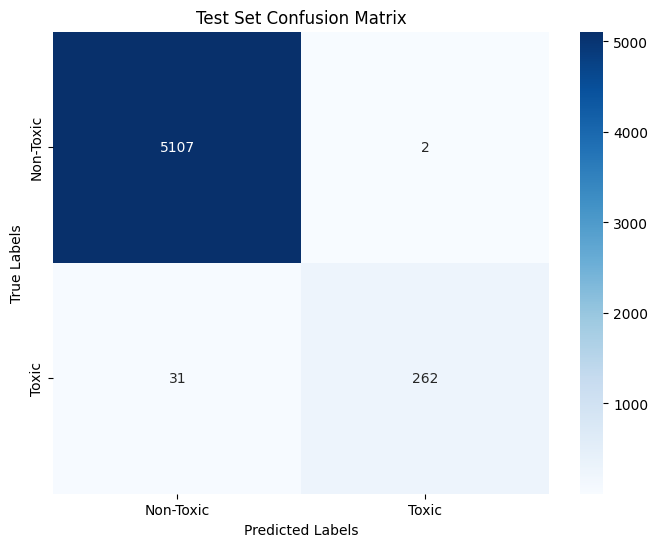

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Import PEFT components
from peft import PeftConfig, PeftModel  # Make sure you have the 'peft' library installed

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """
    Plots the confusion matrix using seaborn's heatmap.
    
    Args:
        y_true (list or array): True labels.
        y_pred (list or array): Predicted labels.
        classes (list): List of class names.
        title (str): Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Define class names (modify if you have different labels)
class_names = ['Non-Toxic', 'Toxic']

# Plot the confusion matrix for the test set
plot_confusion_matrix(test_labels_list, test_preds_list, classes=class_names, title='Test Set Confusion Matrix')



Evaluating on Additional Testing Dataset (testing_25k.csv)...


Testing_25k Loss: 1.1645
Testing_25k Accuracy: 0.4889
Testing_25k Precision: 0.4903
Testing_25k Recall: 0.5601
Testing_25k F1 Score: 0.5229


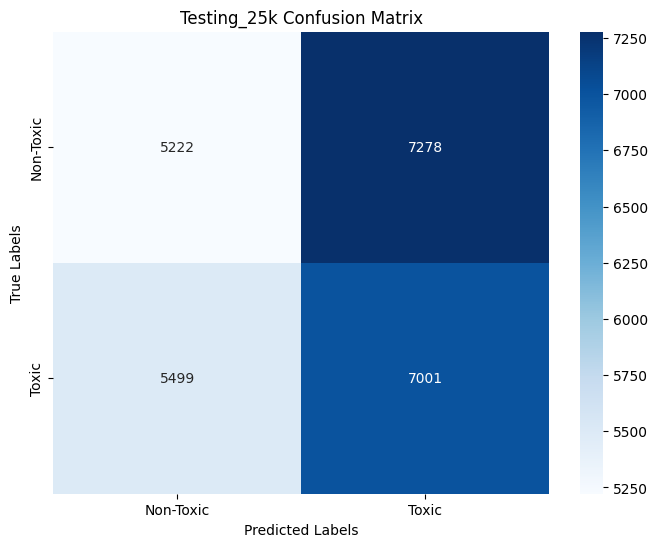

In [6]:
# ================== New Additions Start Here ==================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Load the additional testing dataset 'testing_25k.csv' with the correct label column name
def load_testing25k_data(file_path):
    """
    Loads and preprocesses the testing_25k.csv dataset.

    Args:
        file_path (str): Path to the testing_25k.csv file.

    Returns:
        list: List of texts.
        list: List of labels.
    """
    data = pd.read_csv(file_path)
    data = data.dropna(subset=['text', 'is_toxic'])  # Remove rows with NaN in 'text' or 'labelsis_toxic'
    data['text'] = data['text'].astype(str)  # Ensure all entries in 'text' are strings
    return data["text"].tolist(), data["is_toxic"].tolist()

# Load the 'testing_25k.csv' dataset
testing25k_texts, testing25k_labels = load_testing25k_data("testing_25k.csv")

# 2. Create a Dataset and DataLoader for the new testing data
testing25k_dataset = TextDataset(testing25k_texts, testing25k_labels, tokenizer)
testing25k_dataloader = DataLoader(testing25k_dataset, batch_size=8)

# 3. Evaluate the model on the new testing dataset
print("\nEvaluating on Additional Testing Dataset (testing_25k.csv)...")
model.eval()
testing25k_losses = []
testing25k_labels_list = []
testing25k_preds_list = []

with torch.no_grad():
    progress_bar = tqdm(testing25k_dataloader, desc="Testing 25k", leave=False)
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        testing25k_losses.append(loss.item())

        # Get predictions
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        testing25k_labels_list.extend(labels.cpu().numpy())
        testing25k_preds_list.extend(preds.cpu().numpy())

# 4. Calculate metrics for the new testing dataset
average_testing25k_loss = np.mean(testing25k_losses)
testing25k_accuracy = accuracy_score(testing25k_labels_list, testing25k_preds_list)
testing25k_precision = precision_score(testing25k_labels_list, testing25k_preds_list, zero_division=0)
testing25k_recall = recall_score(testing25k_labels_list, testing25k_preds_list, zero_division=0)
testing25k_f1 = f1_score(testing25k_labels_list, testing25k_preds_list, zero_division=0)

# 5. Print the metrics
print(f"Testing_25k Loss: {average_testing25k_loss:.4f}")
print(f"Testing_25k Accuracy: {testing25k_accuracy:.4f}")
print(f"Testing_25k Precision: {testing25k_precision:.4f}")
print(f"Testing_25k Recall: {testing25k_recall:.4f}")
print(f"Testing_25k F1 Score: {testing25k_f1:.4f}")

# 6. Plot the confusion matrix for the new testing dataset
def plot_confusion_matrix_custom(y_true, y_pred, classes, title='Confusion Matrix'):
    """
    Plots the confusion matrix using seaborn's heatmap.

    Args:
        y_true (list or array): True labels.
        y_pred (list or array): Predicted labels.
        classes (list): List of class names.
        title (str): Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Define class names (modify if you have different labels)
class_names = ['Non-Toxic', 'Toxic']

# Plot the confusion matrix for the testing_25k dataset
plot_confusion_matrix_custom(testing25k_labels_list, testing25k_preds_list, classes=class_names, title='Testing_25k Confusion Matrix')

# ================== New Additions End Here ==================
